## Parse the .xml document from OpenSubtitle

Week 1 -- Week 3

` <s id="11">
    <time id="T11S" value="00:01:51,487" />
    <w id="11.1">I</w>
    <w id="11.2">don</w>
    <w id="11.3">'t</w>
    <w id="11.4">know</w>
    <w id="11.5">,</w>
    <w id="11.6">baby</w>
    <w id="11.7">.</w>
  </s>
  <s id="12">
    <w id="12.1">I</w>
    <w id="12.2">never</w>
    <w id="12.3">looked</w>
    <w id="12.4">.</w>
    <time id="T11E" value="00:01:53,682" />
  </s>
  `
  
---

` <s id="20">
    <time id="T17S" value="00:02:08,687" />
    <w id="20.1">Don</w>
    <w id="20.2">'t</w>
    <w id="20.3">you</w>
    <w id="20.4">want</w>
    <w id="20.5">to</w>
    <w id="20.6">try</w>
    <w id="20.7">the</w>
    <w id="20.8">wheelbarrow</w>
    <w id="20.9">...</w>
    <time id="T17E" value="00:02:11,042" />
    <time id="T18S" value="00:02:11,087" />
    <w id="20.10">or</w>
    <w id="20.11">the</w>
    <w id="20.12">praying</w>
    <w id="20.13">donkey</w>
    <w id="20.14">...</w>
    <time id="T18E" value="00:02:12,486" />
    <time id="T19S" value="00:02:12,527" />
    <w id="20.15">or</w>
    <w id="20.16">the</w>
    <w id="20.17">Chinese</w>
    <w id="20.18">shag</w>
    <w id="20.19">swing</w>
    <w id="20.20">?</w>
    <time id="T19E" value="00:02:14,358" />
  </s>`
  
---

`
  <s id="17">
    <time id="T15S" value="00:02:04,367" />
    <w id="17.1">-</w>
    <w id="17.2">Again</w>
    <w id="17.3">?</w>
  </s>
  <s id="18">
    <w id="18.1">-</w>
    <w id="18.2">Sure</w>
    <w id="18.3">,</w>
    <w id="18.4">baby</w>
    <w id="18.5">.</w>
    <time id="T15E" value="00:02:06,323" />
  </s>
`


1. We have 446612 subtitles in .xml files in total; and approximately 90% of them are in duration between half an hour and three hours. Too short files may be trailer or song lyrics (eg. 666); too long files may be lectures.
2. The subtitles are parsed in such format:


    `<s id = 'NUM'>`: In each `<s>` tag it should mean a sentence by certain character.

    `<time id="T1S" value="00:00:00,668" /> <time id="T1E" value="00:00:02,918" />`: In each `<time>` tag it should mean subtitles shown in one screen.

    Genereally: 
    In each `<s>` tag there is one pair of `<time>` tag;
    In one `<s>` tag if there are more than one pairs of `<time>` tag, it means the sentence by one character is too long and is separeted to put into several screens;
    In one `<time>` tag if there are more than one `<s>` tags, it means different senetences by more than one characters are put in one screen. And these sentences often begin with symbol '-'.


Pre-processing include:
1. Download tokenized English subtitles from http://opus.nlpl.eu/OpenSubtitles2018.php;
2. Convert time to seconds;
3. Select movies with duration between 0.5 - 3 hours;
4. Find sentences in each `<s>` tag (concatenate sentences if in several `<s>` tags; split sentence with '- ')(setences ending with ',' with be considered as part of next sentence. Replace `,<EOS>` with `,` when reading files);
5. Expansion, delete brackets and special symbols, replace numbers with NUM, delete non-dialog (eg. 'Season 1 Episode 1', add <BOS\><EOS\>;
6. Calculate time difference between each sentence, use the 75% percentile as the threshold to separate different dialog.

Problems:
1. Consequent lines may be spoken by same person, and asides are hard to detect (eg. 1858-4037526);
2. Huge looping;
3. Duplicate movies (eg. 0-790764).
4. Subtitle translated from another language. In some files' meta info there has the orignal language.


1. 句号和下一句空格

2. \'s 还可能是所有格

3. 千分秒

4. `<NUM>`

\'ll \'d \'

don 't = **do n't** = do not

can 't = ca n't


In [1]:
import xml.etree.ElementTree as ET
from datetime import datetime,timedelta
import operator
import matplotlib.pyplot as plt
import numpy as np
import os,re,time

import linecache

In [2]:
def time2sec(string):
    # format = '%H:%M:%S'
    # d = datetime.strptime(string, format) 
    # string = string.replace(',','.')
    # d = list(map(float,string.split(':')))
    string = string.replace(' ','')
    d = list(map(float,re.split('\.|,|;|:',string)))
    if len(d) > 3:
        t = timedelta(hours = d[0],minutes = d[1],seconds = d[2]+d[3]/1000)
    else:
        t = timedelta(hours = d[0],minutes = d[1],seconds = d[2])
    return(t.total_seconds())

In [3]:
def multiple_replace(dict_, text):
    # Create a regular expression  from the dictionary keys
    regex = re.compile("(%s)" % "|".join(map(re.escape, dict_.keys())))
    # For each match, look-up corresponding value in dictionary
    return regex.sub(lambda mo: dict_[mo.string[mo.start():mo.end()]], text) 

# dict_sub = {'\"':'\'','´':'\'',
#             '\'s':'is','\'m':'am','\'t':'not','\'ve':'have','\'re':'are',
#             'don not':'do not','didn not':'did not','doesn not':'does not',
#             'haven not':'have not','hasn not':'has not','isn not':'is not','aren not':'are not',
#             'let is':'let us','shouldn not':'should not',
#             'Don not':'Do not','Didn not':'Did not','Doesn not':'Does not',
#             'Haven not':'Have not','Hasn not':'Has not','Isn not':'Is not','Aren not':'Are not',
#             'Let is':'Let us','Shouldn not':'Should not',
#             'in \'':'ing'}
dict_sub = {'\"':'\'','´':'\'',
            ' \'s':'\'s',' \'m':'\'m',' \'ve':'\'ve',' \'re':'\'re',' \'ll':'\'ll',' \'d':'\'d',
            'n \'t':' n\'t', 'in \'':'ing', 'ing \'':'ing'}

In [4]:
def OpenSubtitleSentence(file_path,dict_=dict_sub):
    # import data
    tree = ET.parse(file_path)
    root = tree.getroot()
    time_list = []
    s_list = []
    s_tmp = ''
    flag_s = 0
    flag_e = 0
    flag_m = 0
    
    # get duration of input document
    for sub in root.iter('subtitle'):
        for duration in sub.iter('duration'):
            duration_time = time2sec(duration.text.split(',')[0])    
    # if the duration is too short or too long we ignore this document
    if (duration_time < 3600*0.5) | (duration_time > 3600*3):
        return [],[],None
    
    # To see if the subtitle is translated from another language
    # if the original language is not English then we label it with prefix NEN
    # if the original is missing, then we use prefix OTH(er)
    element = root.find('meta').find('source').find('original')
    if element is not None:
        if element.text:
            if 'English' in element.text:
                prefix = 'EN_'
            else:
                prefix = 'NEN_'
        else:
            prefix = 'OTH_'
    else:
        prefix = 'OTH_'
    
    for child in root:
        if child.tag != 's':
            continue
    
        # get the list of start and end time of each sentence
        # if a movie is in 'E-S' pattern in the whole dialog then time_list = []
        time_tmp = []
        for time in child.iter(tag='time'):
            # time_tmp.append(time.attrib['value'])
            time_tmp.extend([time.attrib['id'],time.attrib['value']])
        
        if not time_tmp:
            flag_m = 1
        elif (time_tmp[0].endswith('S')) & (time_tmp[-2].endswith('E')):
            time_list.extend([time_tmp[1],time_tmp[-1]])
        elif (time_tmp[0].endswith('E')) & (time_tmp[-2].endswith('S')):
            flag_m = 1
        elif (time_tmp[0].endswith('S')) & (time_tmp[-2].endswith('S')):
            time_list.extend([time_tmp[1]])
            flag_s = 1
        elif (time_tmp[0].endswith('E')) & (time_tmp[-2].endswith('E')):
            time_list.extend([time_tmp[-1]])
            flag_e = 1
        
        s = [] # sentence in this loop
        if child.itertext(): #sentence in each s tag
            s.append(''.join(child.itertext()))
        s = ' '.join(s[0].split())
        a = s
                
        if flag_s:
            s_tmp = a
            flag_s = 0
            continue
        
        if flag_m:
            try:
                s_tmp = s_tmp +' ' + a
            except:
                print(child.attrib)
            flag_m = 0
            continue
            
        if flag_e:
            a = s_tmp + ' ' + a
            flag_e = 0
            s_tmp = ''
        
        a = multiple_replace(dict_, a)
        a = multiple_replace(dict_, a)
        a = re.sub('ca n\'t','can n\'t',a)
        
        # remove brackets and contents in the brackets/special symbols
        a = re.sub(u"\\(.*?\\)|\\{.*?}|\\[.*?]|\\♪.*?♪|\\#.*?#|\\=.*?=|\\¶.*?¶", "", a)
        a = re.sub('[0-9]+', '<NUM>', a) # replace specific number with NUM
        # a = a.replace('-','')
        a = a.lstrip().rstrip()# remove '-' and spaces before or after sentence
            
        if (not len(a)) | (any(re.findall(r' Season.*?Episode |Subtitles|Subtitle | Episode ',a, re.IGNORECASE))) |(not (any(re.findall(r'\.|,|\?|!|\'|\"',a)))): 
            # skip null sentence; delete  '- Season x Episode x -' or 'Subtitles by' lines;
            # delete non-dialog sentences, eg. titles of episode
            del time_list[-2:]
            continue
            
        s_list.append(a)
                
    # convert to seconds
    time_second = []
    for time in time_list:
        # print(child.attrib,time)
        time_second.append(time2sec(time))

    time_diff = list(map(operator.sub,time_second[::2][1:],time_second[1::2][:-1]))
    
    return s_list,time_diff,prefix

In [5]:
def SaveSentence(save_path,s_,time_):
    n = 1
    new_path = save_path
    while os.path.exists(new_path):
        new_path = save_path.split('.')[0]+'_'+str(n)+'.txt'
        n +=1
    
    time_th = round(np.percentile(time_diff,75),3)
    f = open(new_path,'a')
    for i in range(len(s_)-1):
        a = s_[i]
        a = '<EOS>'.join(list(filter(None,a.split(u"- "))))
        a = a+'<EOS>'
        f.write(a)
        # f.write("\n")
        if time_[i]>=time_th:
            # f.write(">>>>>")
            f.write("\n")
    a = s_[i+1]
    a = '\n'.join(list(filter(None,a.split('- '))))
    a = a+'<EOS>'
    f.write(a)
    # print(new_path)
    return

In [6]:
file_count=0
folder_path = "/Volumes/Files/en/OpenSubtitles/"

# for dirpath, dirnames, filenames in os.walk('/Volumes/Files/en/OpenSubtitles/xml/en/'):
#     for file in filenames:
#         tmp_path = os.path.join(dirpath,file)
#         f = open(folder_path+'AllFilePath.txt','a')
#         f.write(tmp_path)
#         f.write('\n')
#         file_count=file_count+1
file_count = 446612
print(file_count)
# file_count = 446612

446612


In [7]:
g = os.walk("/Volumes/Files/en/OpenSubtitles/xml/en/")
folder_path = "/Volumes/Files/en/OpenSubtitles/txt/"
file_path = "/Volumes/Files/en/OpenSubtitles/AllFilePath.txt"

cnt = 0
tos = time.clock()

# g = os.walk('./')
# folder_path = './'
# looping over all .xml files in that folder
# for path,dir_list,file_list in g:  
#     for file_name in file_list:

bias =400000
for i in range(bias+1,446613):
    tmp_path = linecache.getline(file_path, i).strip()
    if cnt%3000 == 0:
        runtime = time.clock()-tos
        time.sleep(60)
        # tos = runtime
        print('\n')
        print('============================')
        print('Processing :',cnt,'running time is',runtime,'s')
        print('============================','\n')
#         if file_name.endswith(".xml"): 
#             tmp_path = os.path.join(path,file_name)
    # save dialogue           
    try:
        s_list,time_diff,prefix_ = OpenSubtitleSentence(tmp_path)
        if len(s_list) & len(time_diff):
            save_path = folder_path + prefix_+ os.path.basename(tmp_path).split('.')[0] + '.txt' 
            SaveSentence(save_path,s_list,time_diff)       
    except Exception as e:
        f = open(folder_path+'Error.txt','a')
        f.write(tmp_path+'Error line: '+str(cnt))
        f.write('\n')
    cnt += 1
print(time.clock()-tos)
print(i)

/anaconda3/envs/semester/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/anaconda3/envs/semester/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead




Processing : 0 running time is 0.0002500000000509317 s



Processing : 3000 running time is 132.11438499999986 s



Processing : 6000 running time is 311.42041500000005 s



Processing : 9000 running time is 520.5034959999998 s



Processing : 12000 running time is 675.9209510000001 s



Processing : 15000 running time is 824.4574069999999 s



Processing : 18000 running time is 958.508758 s



Processing : 21000 running time is 1092.9165669999998 s



Processing : 24000 running time is 1226.110177 s



Processing : 27000 running time is 1352.0267319999998 s



Processing : 30000 running time is 1470.302337 s



Processing : 33000 running time is 1651.7445010000001 s



Processing : 36000 running time is 1791.0520049999996 s



Processing : 39000 running time is 1927.2329979999995 s



Processing : 42000 running time is 2050.0826289999995 s



Processing : 45000 running time is 2166.135837 s

2224.482844
446612


/anaconda3/envs/semester/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [23]:
13/16

0.8125

In [25]:
print(i)

200000


 1 - 10000: 112,349,604,678
 10001 - 20000 : 214,391,589,649
 20001 - 30000 : 160,318,470,526
 30001 - 40000 : 160,303,476,543
 40001 - 60000 : 179,350,518,712,874,1042,1159
 60001 - 80000 : 159, 328,536,702,852,1030,1171
 80001 - 100000 : 151,324,512,641,858,959,1143
8,838, 512 MB
 
 

In [10]:
# the root data folder 
#g = os.walk("/Volumes/Files/en/OpenSubtitles/xml/en/")
g = os.walk('./')

total_time = []
total_dura = []
tos = time.clock()
# looping over all .xml files in that folder
for path,dir_list,file_list in g:  
    for file_name in file_list:
        if file_name.endswith(".xml"): 
            tmp_path = os.path.join(path,file_name)    
            s_list,time_diff,prefix_ = OpenSubtitleSentence(tmp_path)
            save_path = os.path.basename(tmp_path).split('.')[0] + '.txt' 
            if len(s_list) & len(time_diff):
                SaveSentence(prefix_+save_path,s_list,time_diff)


/anaconda3/envs/semester/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


In [44]:
def OpenSubtitleOriginal(file_path):
    # import data
    tree = ET.parse(file_path)
    root = tree.getroot()

    # To see if the subtitle is translated from another language
    # if the original language is not English then we skip this file
    element = root.find('meta').find('source').find('original')
    if element is not None:
        if element.text:
            return element.text
    return 'Other'


In [45]:
file_path = "/Volumes/Files/en/OpenSubtitles/AllFilePath.txt"

language = []
cnt = 0
tos = time.clock()
for i in range(1,10001):
    if cnt%3000 == 0:
        runtime = time.clock()-tos
        time.sleep(60)
        # tos = runtime
        print('\n')
        print('============================')
        print('Processing :',cnt,'running time is',runtime,'s')
        print('============================','\n')
#         if file_name.endswith(".xml"): 
#             tmp_path = os.path.join(path,file_name)
    tmp_path = linecache.getline(file_path, i).strip()
    language.extend(OpenSubtitleOriginal(tmp_path).split(','))
    cnt += 1

/anaconda3/envs/semester/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/anaconda3/envs/semester/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  




Processing : 0 running time is 0.0005199999999945248 s



Processing : 3000 running time is 54.911463 s



Processing : 6000 running time is 174.999783 s



Processing : 9000 running time is 294.39956599999994 s



In [47]:
import pandas as pd

lang_pd = pd.Series(language)

---

(array([5.363e+03, 4.582e+03, 1.210e+02, 1.100e+01, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([    0. ,  5423.3, 10846.6, 16269.9, 21693.2, 27116.5, 32539.8,
        37963.1, 43386.4, 48809.7, 54233. ]),
 <a list of 10 Patch objects>)

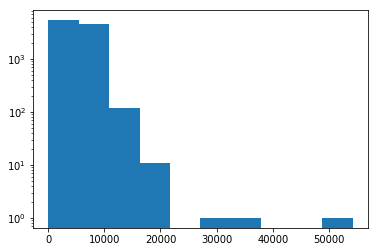

In [5]:
plt.hist(total_dura[1:],log=True)

(array([ 41.,  73., 182.,  83.,  62.,  37.,  86., 225., 107.,  92.]),
 array([   0. ,  179.7,  359.4,  539.1,  718.8,  898.5, 1078.2, 1257.9,
        1437.6, 1617.3, 1797. ]),
 <a list of 10 Patch objects>)

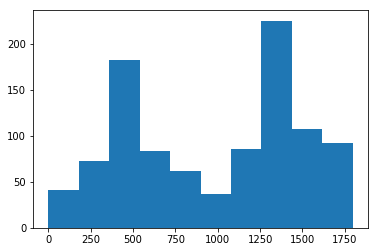

In [9]:
test = np.array(total_dura)
test = test[test<1800]
plt.hist(test)

In [8]:
tree = ET.parse(tmp_path)
root = tree.getroot()


In [63]:
element = root.find('meta').find('source').find('original')
if element is not None:
    if element.text:
        if 'English' in element.text:
            prefix = 'EN'
        else:
            prefix = 'NEN'
    else:
        prefix = 'OTH'
else:
    prefix = 'OTH'
prefix

'EN'

In [10]:
s_list,time_diff,prefix_ = OpenSubtitleSentence(tmp_path)

In [11]:
prefix_

'EN_'

In [8]:
save_path

NameError: name 'save_path' is not defined